# Dashboard Preparation

In [1]:
import json
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

['Was Acquired' 'Made Acquisitions' 'Made Acquisitions, Was Acquired']
['Seed' 'No Funding' 'Venture - Series Unknown' 'Series A' 'Series B'
 'Convertible Note' 'Angel' 'Post-IPO Debt' 'Private Equity' 'Pre-Seed'
 'Grant' 'Series C' 'Series F' 'Series D' 'Post-IPO Secondary' 'Series E'
 'Post-IPO Equity']
3608 investors could not be found.


/Users/janlinzner/Library/Mobile Documents/com~apple~CloudDocs/Documents/McGill/1_Lectures/Decision Analytics (MGSC 662)/2_Coding/Exercises/ADA_Coding/Code/FeatureEngineering.ipynb:1497: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  companies.fillna(0, inplace=True)
/Users/janlinzner/Library/Mobile Documents/com~apple~CloudDocs/Documents/McGill/1_Lectures/Decision Analytics (MGSC 662)/2_Coding/Exercises/ADA_Coding/Code/FeatureEngineering.ipynb:2529: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

Recognition Rate: 91.04%
Total Entries with Degrees: 1663
Recognized Degrees: 1514
Series([], dtype: int64)
Remaining rows after dropping NaNs: 1518
Strongly correlated feature pairs:
Average Funding Size and Last Funding Amount with a correlation of 0.91
followers_max_growth and followers_Twitter with a correlation of 0.91
tweet_activity and tweets with a correlation of 0.93
Average Time To Next Round and Months until First Round with a correlation of 0.87
Months between Founding and Acquisition and Was Acquired with a correlation of 0.92
Average Number of Portfolio Organizations by Investors and Average Number of Investments by Investors with a correlation of 0.93
Industry_data and analytics and Industry_artificial intelligence (ai) with a correlation of 0.84
min_linkedin_followers_founders and average_linkedin_followers_founders with a correlation of 1.00
max_linkedin_followers_founders and average_linkedin_followers_founders with a correlation of 1.00
min_linkedin_connections_found

/Users/janlinzner/Library/Mobile Documents/com~apple~CloudDocs/Documents/McGill/1_Lectures/Decision Analytics (MGSC 662)/2_Coding/Exercises/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[LightGBM] [Info] Number of positive: 1003, number of negative: 1003
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9974
[LightGBM] [Info] Number of data points in the train set: 2006, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/janlinzner/Library/Mobile Documents/com~apple~CloudDocs/Documents/McGill/1_Lectures/Decision Analytics (MGSC 662)/2_Coding/Exercises/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
               Model  Accuracy  Precision    Recall  F1-Score       AUC
0  Gradient Boosting  0.865132   0.779229  0.702511  0.730164  0.767797
1           LightGBM  0.868421   0.793134  0.697061  0.729128  0.788018
2     Neural Network  0.822368   0.682883  0.654289  0.666016  0.711757
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


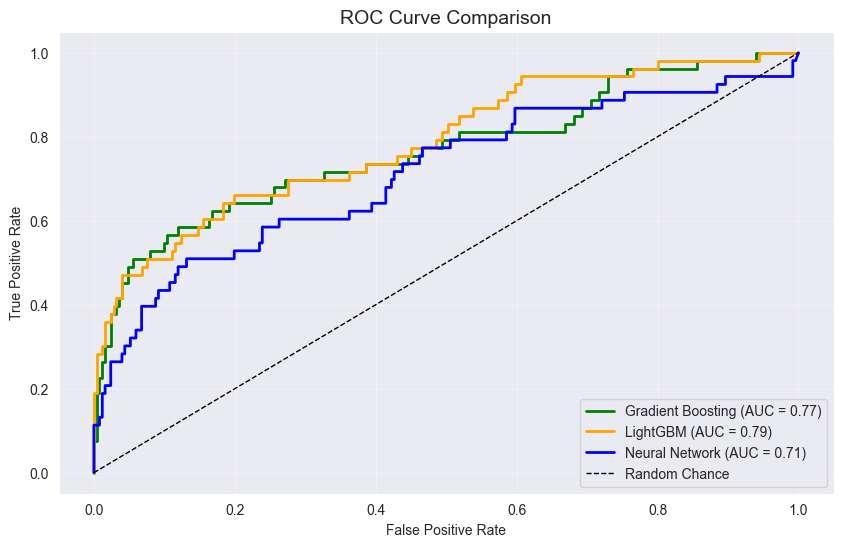

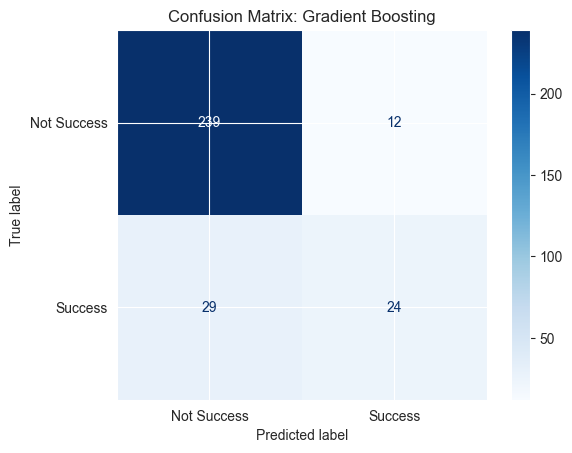

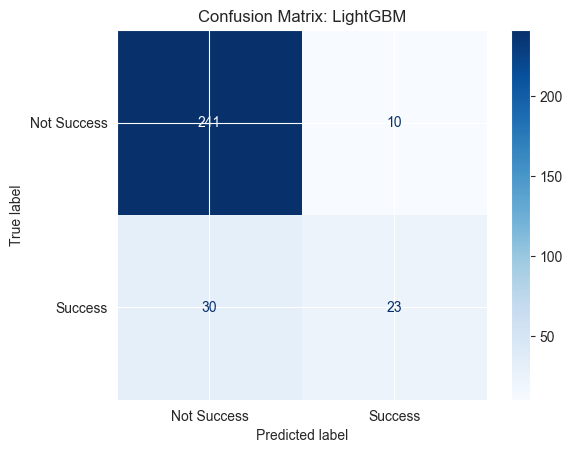

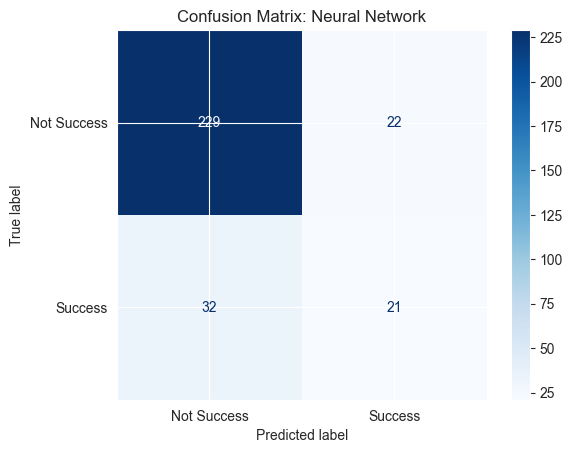

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


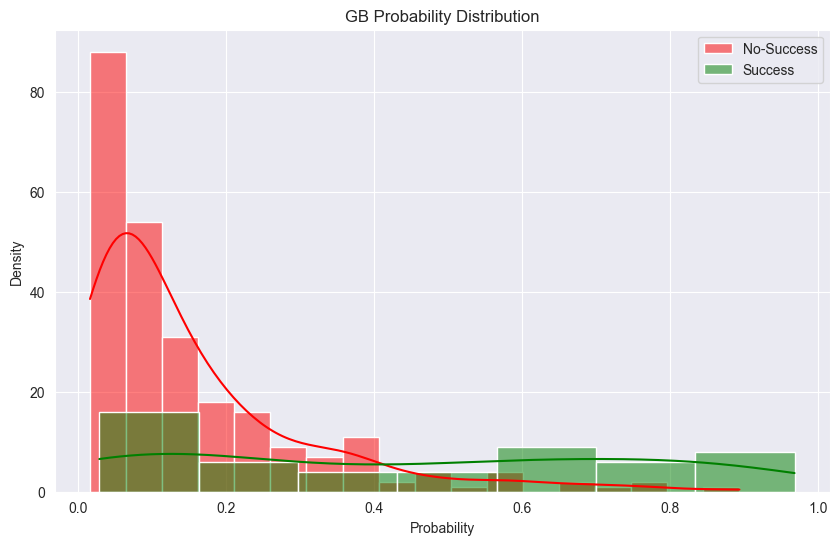

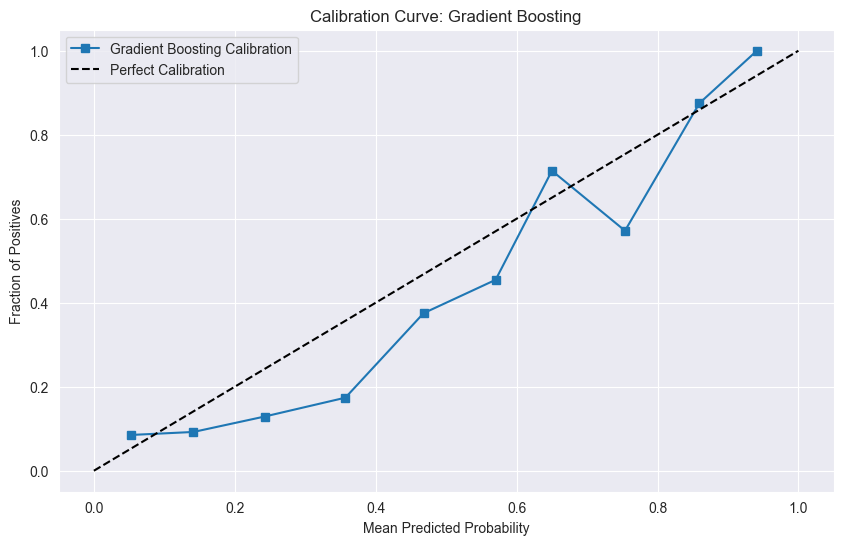

/Users/janlinzner/Library/Mobile Documents/com~apple~CloudDocs/Documents/McGill/1_Lectures/Decision Analytics (MGSC 662)/2_Coding/Exercises/ADA_Coding/Code/Modeling.ipynb:2576: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="True Class (Test)", y=f"{model_name} Probability (Success, Test)", data=df, palette="muted")


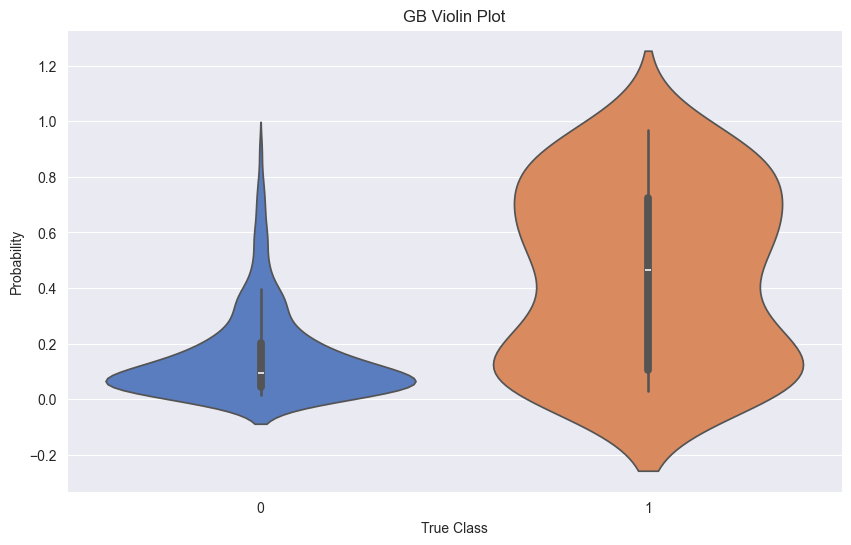

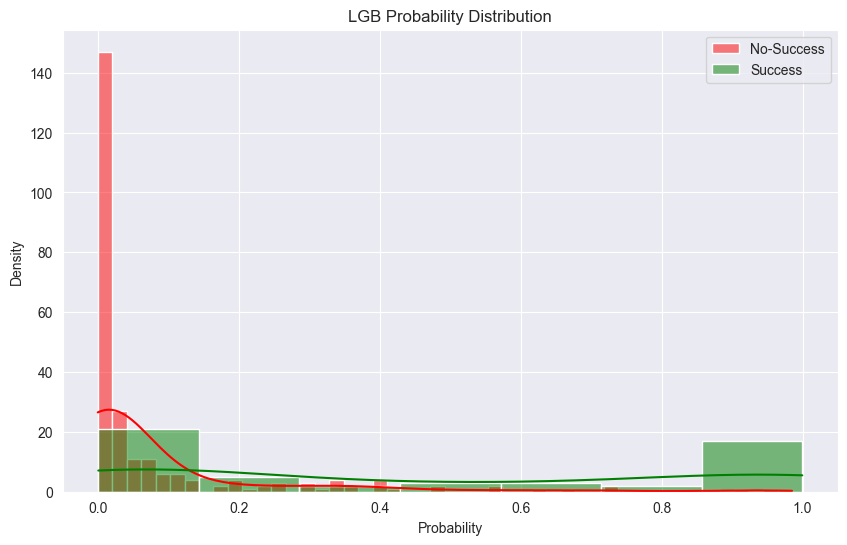

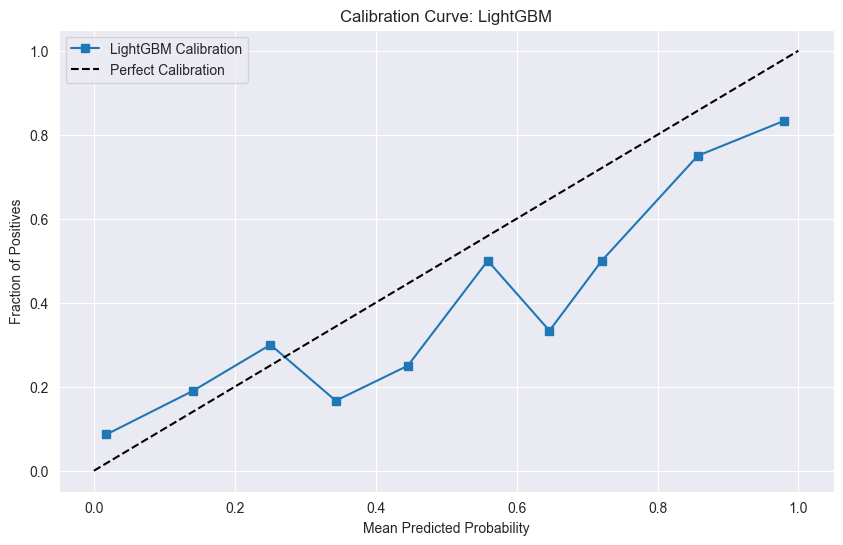

/Users/janlinzner/Library/Mobile Documents/com~apple~CloudDocs/Documents/McGill/1_Lectures/Decision Analytics (MGSC 662)/2_Coding/Exercises/ADA_Coding/Code/Modeling.ipynb:2576: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="True Class (Test)", y=f"{model_name} Probability (Success, Test)", data=df, palette="muted")


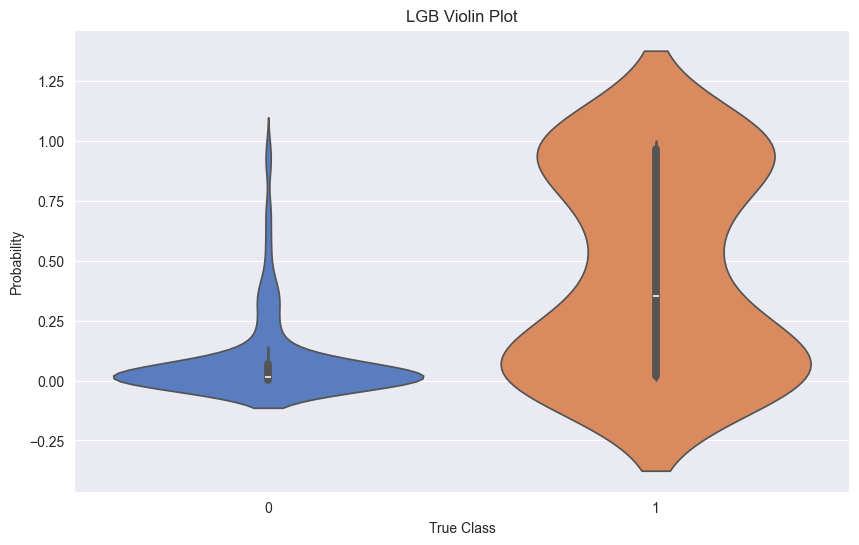

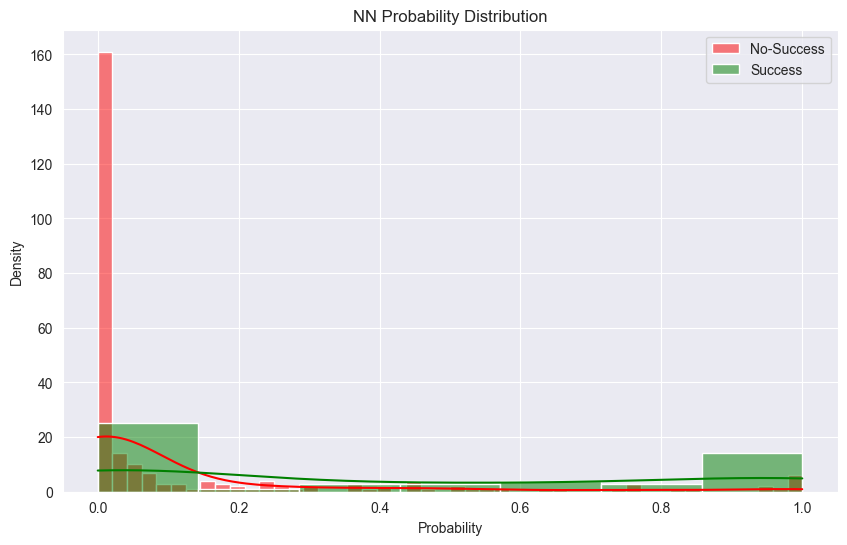

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step


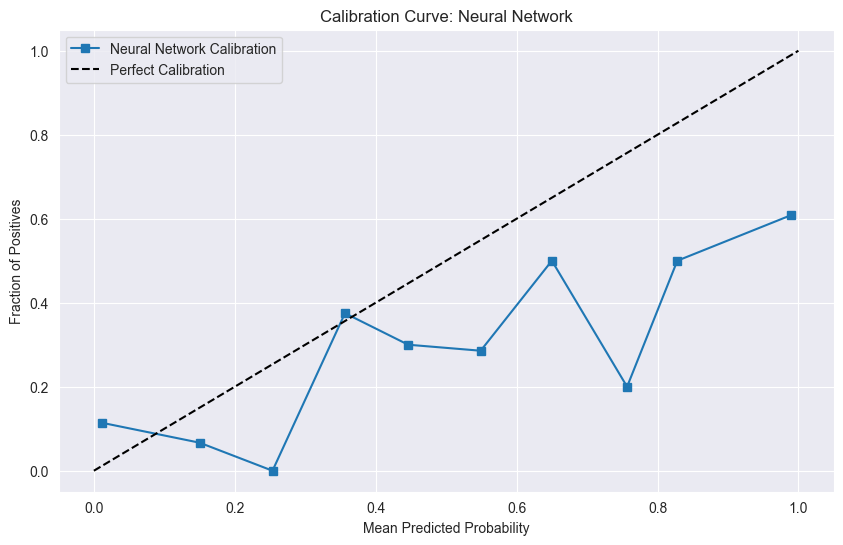

/Users/janlinzner/Library/Mobile Documents/com~apple~CloudDocs/Documents/McGill/1_Lectures/Decision Analytics (MGSC 662)/2_Coding/Exercises/ADA_Coding/Code/Modeling.ipynb:2576: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="True Class (Test)", y=f"{model_name} Probability (Success, Test)", data=df, palette="muted")


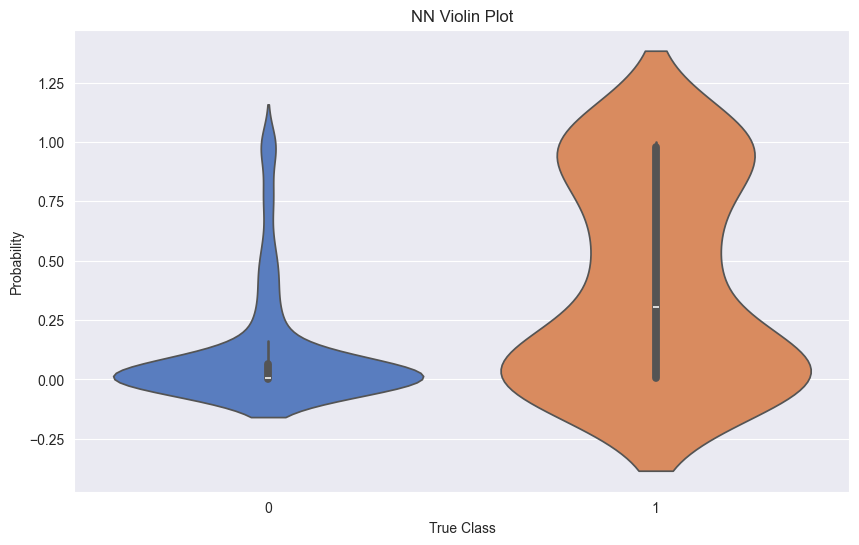

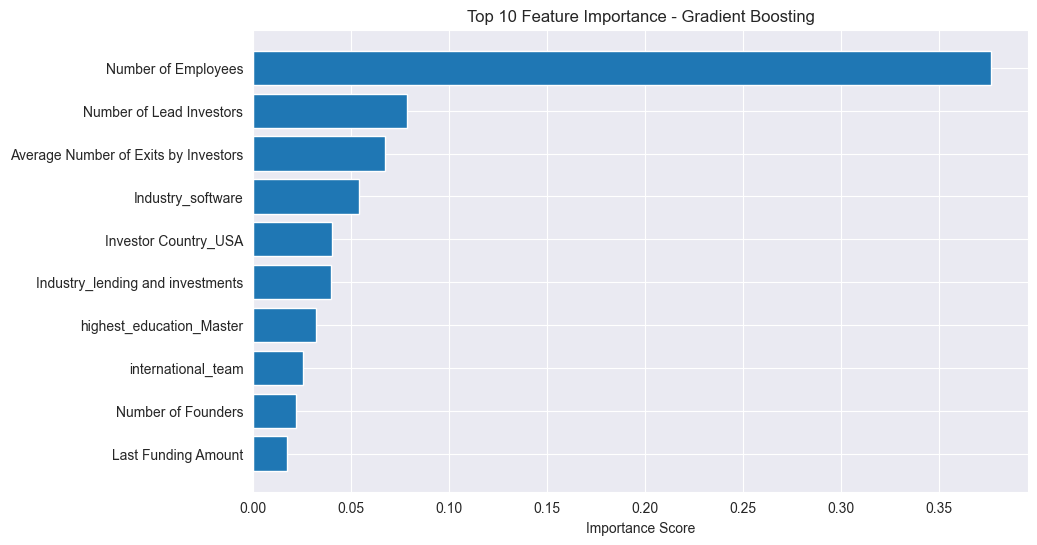

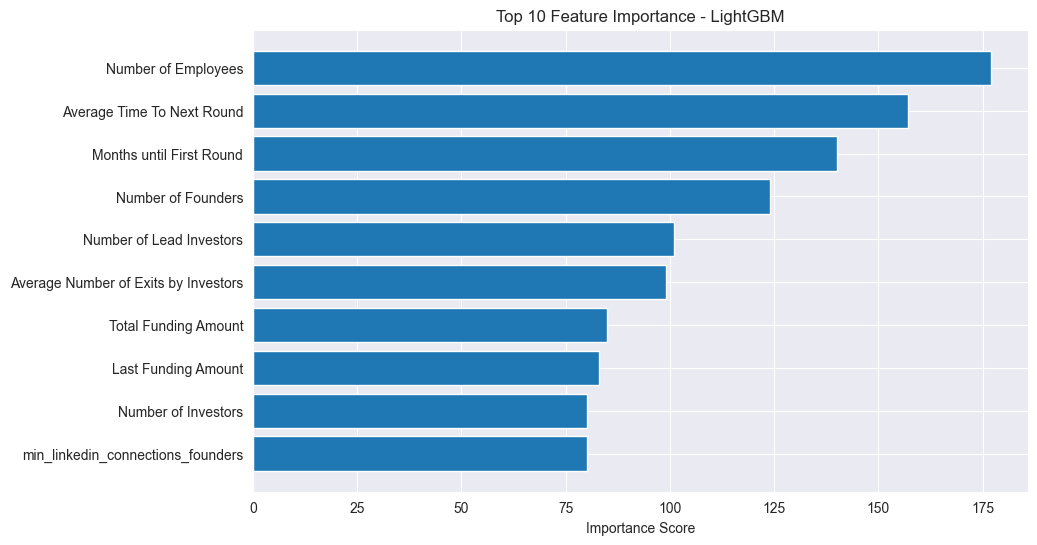

Analyzing Gradient Boosting Model...
Gradient Boosting SHAP Summary Plot:


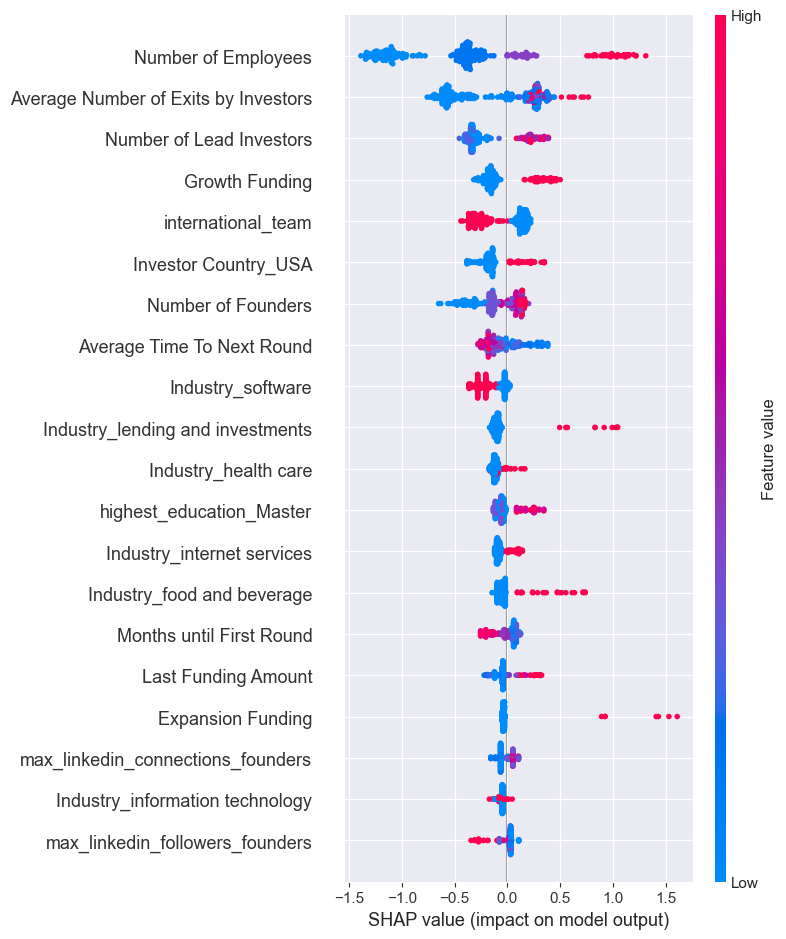

Gradient Boosting SHAP Bar Plot:


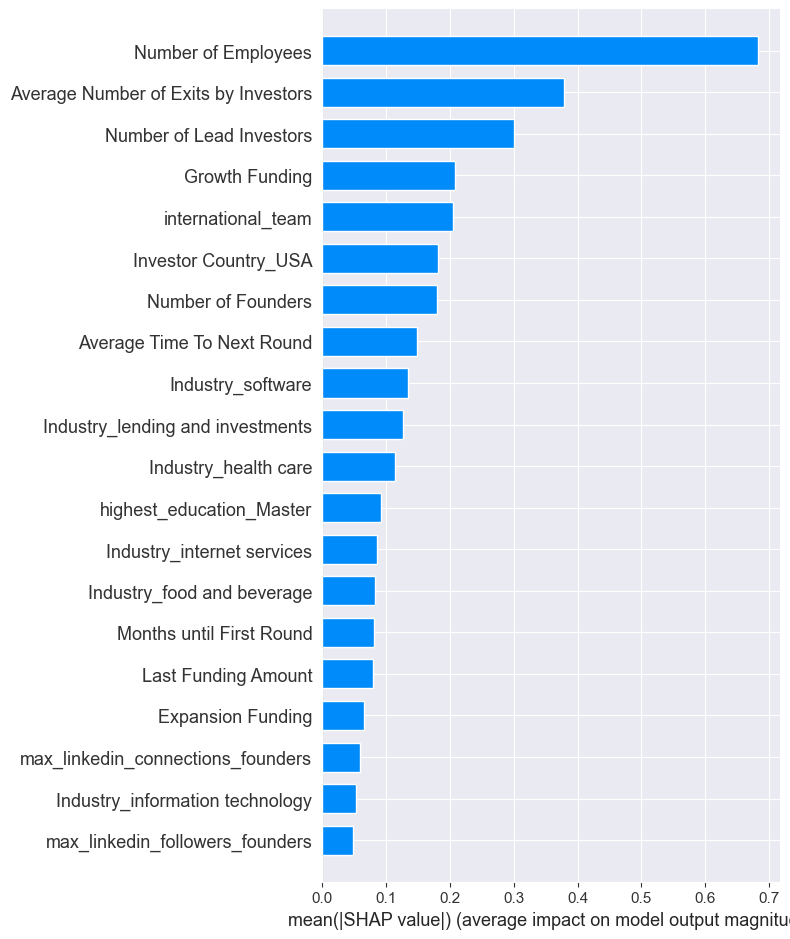

Analyzing LightGBM Model...
LightGBM SHAP Summary Plot:


/Users/janlinzner/Library/Mobile Documents/com~apple~CloudDocs/Documents/McGill/1_Lectures/Decision Analytics (MGSC 662)/2_Coding/Exercises/venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


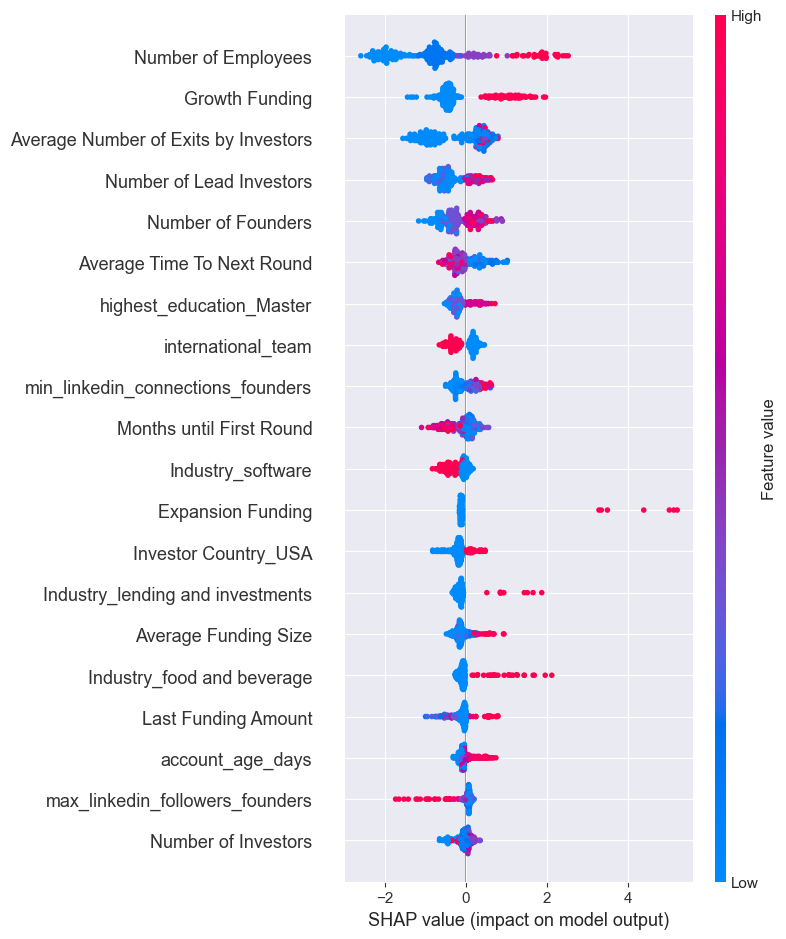

LightGBM SHAP Bar Plot:


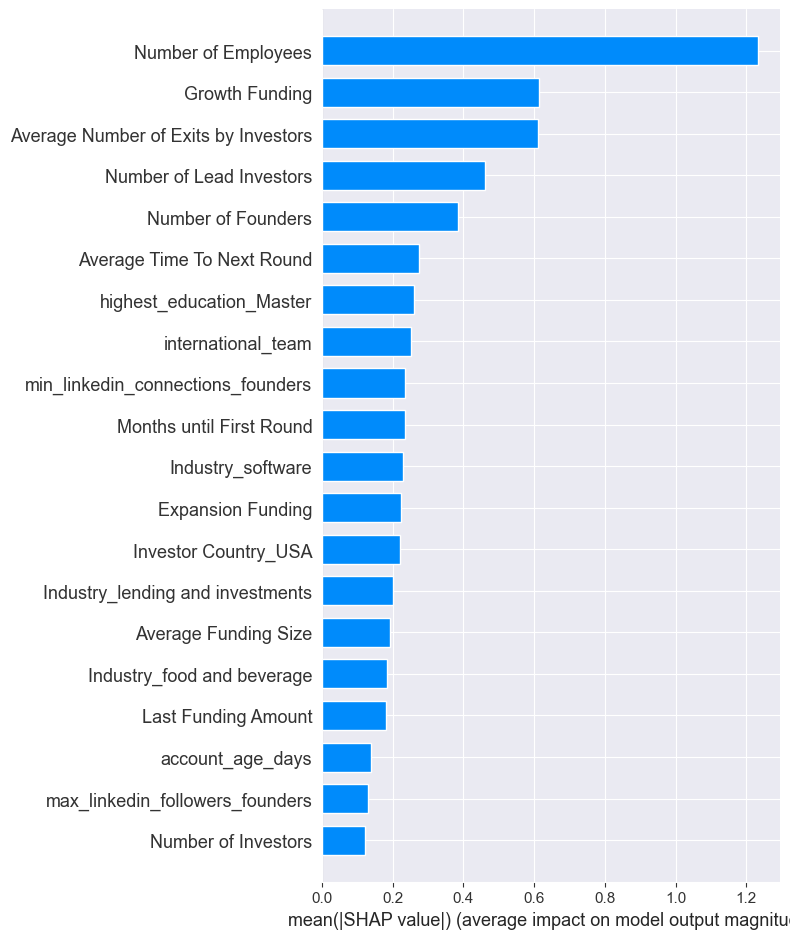

In [2]:
with Notebook():
    from Modeling import data, test_results

In [14]:
def prepare_dashboard_data(test_results):
    def prepare_confusion_matrix_section(true_class, predicted_class):
        tn, fp, fn, tp = confusion_matrix(true_class, predicted_class).ravel()
        return {
            "truePositive": int(tp),
            "trueNegative": int(tn),
            "falsePositive": int(fp),
            "falseNegative": int(fn)
        }

    def transform_results(results, prediction_column, probability_column):
        transformed = []
        for _, row in results.iterrows():
            transformed.append({
                "id": row["Observation Index"],
                "actualLabel": "Positive" if row["True Class (Test)"] == 1 else "Negative",
                "predictedLabel": "Positive" if row[prediction_column] == 1 else "Negative",
                "confidence": f"{row[probability_column] * 100:.2f}%",
                "timestamp": pd.Timestamp.now().isoformat()  # Beispiel für einen Zeitstempel
            })
        return transformed

    gb_data = {
        "name": "Gradient Boosting",
        "stats": {
            "accuracy": (test_results['True Class (Test)'] == test_results['GB Prediction (Test)']).mean(),
            "precision": classification_report(
                test_results['True Class (Test)'],
                test_results['GB Prediction (Test)'],
                output_dict=True
            )['macro avg']['precision'],
            "recall": classification_report(
                test_results['True Class (Test)'],
                test_results['GB Prediction (Test)'],
                output_dict=True
            )['macro avg']['recall'],
            "f1Score": classification_report(
                test_results['True Class (Test)'],
                test_results['GB Prediction (Test)'],
                output_dict=True
            )['macro avg']['f1-score']
        },
        "confusionMatrix": prepare_confusion_matrix_section(
            test_results['True Class (Test)'],
            test_results['GB Prediction (Test)']
        ),
        "results": transform_results(
            test_results, "GB Prediction (Test)", "GB Probability (Success, Test)"
        ),
        "paperUrl": "https://arxiv.org/abs/1603.02754"
    }

    lgb_data = {
        "name": "LightGBM",
        "stats": {
            "accuracy": (test_results['True Class (Test)'] == test_results['LGB Prediction (Test)']).mean(),
            "precision": classification_report(
                test_results['True Class (Test)'],
                test_results['LGB Prediction (Test)'],
                output_dict=True
            )['macro avg']['precision'],
            "recall": classification_report(
                test_results['True Class (Test)'],
                test_results['LGB Prediction (Test)'],
                output_dict=True
            )['macro avg']['recall'],
            "f1Score": classification_report(
                test_results['True Class (Test)'],
                test_results['LGB Prediction (Test)'],
                output_dict=True
            )['macro avg']['f1-score']
        },
        "confusionMatrix": prepare_confusion_matrix_section(
            test_results['True Class (Test)'],
            test_results['LGB Prediction (Test)']
        ),
        "results": transform_results(
            test_results, "LGB Prediction (Test)", "LGB Probability (Success, Test)"
        ),
        "paperUrl": "https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree"
    }

    nn_data = {
        "name": "Neural Network",
        "stats": {
            "accuracy": (test_results['True Class (Test)'] == test_results['NN Prediction (Test)']).mean(),
            "precision": classification_report(
                test_results['True Class (Test)'],
                test_results['NN Prediction (Test)'],
                output_dict=True
            )['macro avg']['precision'],
            "recall": classification_report(
                test_results['True Class (Test)'],
                test_results['NN Prediction (Test)'],
                output_dict=True
            )['macro avg']['recall'],
            "f1Score": classification_report(
                test_results['True Class (Test)'],
                test_results['NN Prediction (Test)'],
                output_dict=True
            )['macro avg']['f1-score']
        },
        "confusionMatrix": prepare_confusion_matrix_section(
            test_results['True Class (Test)'],
            test_results['NN Prediction (Test)']
        ),
        "results": transform_results(
            test_results, "NN Prediction (Test)", "NN Probability (Success, Test)"
        ),
        "paperUrl": "https://arxiv.org/abs/1512.03385"
    }

    dashboard_data = [gb_data, lgb_data, nn_data]

    with open("dashboard_data.json", "w") as f:
        json.dump(dashboard_data, f, indent=4)

    print("Dashboard data saved to dashboard_data.json")

Dashboard data saved to dashboard_data.json


In [15]:
prepare_dashboard_data(test_results)

Dashboard data saved to dashboard_data.json
